自己一直很感兴趣的影像数据，想试一下

In [ ]:
!nvidia-smi

In [ ]:
!wget http://bioinfo.konkuk.ac.kr/DLEB/data/example_image.tar.gz

In [3]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!tar -zxvf /content/example_image.tar.gz

In [1]:
import numpy as np
from PIL import Image
img = Image.open("/content/example_image/example_images.toy_data/insitu10005.jpg")
imgArray = np.array(img)
print(imgArray.shape)

(128, 320, 3)


In [2]:
match = {'stage1-3': 0, 'stage4-6': 1, 'stage7-8': 2, 'stage9-10': 3, 'stage11-12': 4, 'stage13-16': 5}

In [3]:
data_file=('/content/example_image/image_stage.toy_data.label.txt')

label_list, feature_list= [], []

with open(data_file) as f:
  for line in f.readlines()[1:]:
    file,label = line.strip().split('\t')
    matv = match[label]
    img = Image.open("/content/example_image/example_images.toy_data/"+file)
    feature = np.array(img)/255  #试试图片归一化？我这么归一化是不是把灰度值也除了255
    label_list.append(matv)
    feature_list.append(feature)

In [ ]:
#print(label_list[2],feature_list[2]) #有点没想明白哪里出问题了，但肯定是有问题的

先做一个简单的CNN试试

In [4]:
label_list = np.array(label_list)
feature_list = np.array(feature_list) #少整几个变量出来，缓解内存压力

In [6]:
print(label_list.shape,label_list[1])

(3565,) 3


报错，应该对于label需要有什么转换？

In [7]:
from keras.utils import to_categorical
label_list = to_categorical(label_list,6)

In [8]:
print(label_list[1])

[0. 0. 0. 1. 0. 0.]


In [10]:
import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras import optimizers
import tensorflow as tf


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature_list, label_list, test_size = 0.25, random_state = 10)

In [ ]:
model = Sequential()
model.add(Input(shape=(128,320,3)))
model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu')) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2))) 
model.add(Flatten())                                                              
model.add(Dense(125, activation='relu')) 
model.add(Dropout(0.2))  
model.add(Dense(50, activation='relu'))                                               
model.add(Dense(6, activation='softmax'))              

model.summary()

#opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = 'Adam',                    
       loss = 'categorical_crossentropy',    
       metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=125, validation_data=(x_test, y_test),
                    epochs=30, validation_split=0.2)

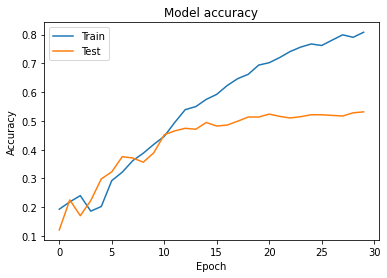

In [ ]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 
#之前把训练集和测试集的比例写错了，改完之后倒是训练什么的都正常了
#感觉泛化的能力很差啊，训练集的ACC和测试集差好多

残差网络

In [11]:
x_train.shape[1:]

(128, 320, 3)

In [12]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# 训练参数
batch_size = 32  # 原论文按照 batch_size=128 训练所有的网络
epochs = 200
data_augmentation = False
num_classes = 6

n = 6
version = 2 #有一个对照的表格可以看用哪个版本的残差，什么的

# 从提供的模型参数 n 计算的深度
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# 模型名称、深度和版本
model_type = 'ResNet%dv%d' % (depth, version)

# 输入图像维度。
input_shape = x_train.shape[1:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
         num_filters=16,
         kernel_size=3,
         strides=1,
         activation='relu',
         batch_normalization=True,
         conv_first=True):
    conv = Conv2D(num_filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=6):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # 开始模型定义
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # 实例化残差单元的堆栈
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # 第一层但不是第一个栈
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                      num_filters=num_filters,
                      strides=strides)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters,
                      activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # 线性投影残差快捷键连接，以匹配更改的 dims
                x = resnet_layer(inputs=x,
                          num_filters=num_filters,
                          kernel_size=1,
                          strides=strides,
                          activation=None,
                          batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # 在顶层加分类器。
    # v1 不在最后一个快捷连接 ReLU 后使用 BN
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
             activation='softmax',
             kernel_initializer='he_normal')(y)

    # 实例化模型。
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=6):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # 开始模型定义。
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 在将输入分离为两个路径前执行带 BN-ReLU 的 Conv2D 操作。
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # 实例化残差单元的栈
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # 瓶颈残差单元
            y = resnet_layer(inputs=x,
                      num_filters=num_filters_in,
                      kernel_size=1,
                      strides=strides,
                      activation=activation,
                      batch_normalization=batch_normalization,
                      conv_first=False)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters_in,
                      conv_first=False)
            y = resnet_layer(inputs=y,
                      num_filters=num_filters_out,
                      kernel_size=1,
                      conv_first=False)
            if res_block == 0:
                # 线性投影残差快捷键连接，以匹配更改的 dims
                x = resnet_layer(inputs=x,
                          num_filters=num_filters_out,
                          kernel_size=1,
                          strides=strides,
                          activation=None,
                          batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # 在顶层添加分类器
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
             activation='softmax',
             kernel_initializer='he_normal')(y)

    # 实例化模型。
    model = Model(inputs=inputs, outputs=outputs)
    return model

x_train shape: (2673, 128, 320, 3)
2673 train samples
892 test samples
y_train shape: (2673, 6)


In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
       optimizer='adam',metrics=['accuracy'])

model.summary()

In [14]:
print(model_type)

ResNet56v2


In [15]:
import tensorflow as tf

In [16]:
gpuConfig = tf.compat.v1.ConfigProto(allow_soft_placement=True)
gpuConfig.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.compat.v1.Session(config=gpuConfig)  #限制了显存的使用之后能够正常的进行训练了

In [17]:
save_dir = '/content/gdrive/MyDrive/my_ai/'
model_name = 'resnet_image_model.{epoch:03d}.h5'

filepath = os.path.join(save_dir, model_name) #突然发现我并没有挂载我都google driver

# 准备保存模型和学习速率调整的回调。
checkpoint = ModelCheckpoint(filepath=filepath,
                monitor='val_loss',
                verbose=1,
                save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                 cooldown=0,
                 patience=5,
                 min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

#
history = model.fit(x_train, y_train,
           batch_size=32,epochs=20,
           validation_data=(x_test, y_test),
           shuffle=True,callbacks=callbacks)  

#为了不爆显存，这里batch_size用的32，慢慢悠悠的，倒是也能跑，我想试试跑个2，3十次迭代
#感觉，残差确实效果要好得多，每一次迭代都很好的提升了性能，10次迭代时训练集ACC是0.68

Learning rate:  0.001
Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 2.9869 - accuracy: 0.2944
Epoch 1: val_loss improved from inf to 4.67876, saving model to /content/gdrive/MyDrive/my_ai/resnet_image_model.001.h5
84/84 [==============================] - 131s 1s/step - loss: 2.9869 - accuracy: 0.2944 - val_loss: 4.6788 - val_accuracy: 0.1603 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 2.5726 - accuracy: 0.3958
Epoch 2: val_loss improved from 4.67876 to 2.92492, saving model to /content/gdrive/MyDrive/my_ai/resnet_image_model.002.h5
84/84 [==============================] - 109s 1s/step - loss: 2.5726 - accuracy: 0.3958 - val_loss: 2.9249 - val_accuracy: 0.2679 - lr: 0.0010
Learning rate:  0.001
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 2.3233 - accuracy: 0.4890
Epoch 3: val_loss improved from 2.92492 to 2.71564, saving model to /content/gdrive/MyDrive/my_ai/resnet_image_model.003.h

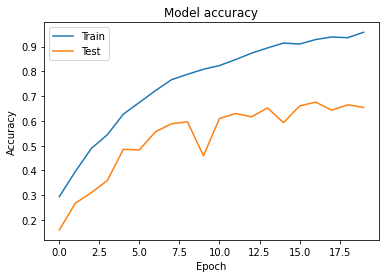

In [18]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 

跑了20次迭代，效果，会好一些，但提升还挺有限了，十次迭代升到了0.68，但是二十次迭代也没有比0.68更好，就，emmmmm，不知道更多次的迭代会不会更好，感觉如果